In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import cross_decomposition

%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%run ./skills.py # contains subsetSkills, createCountryPenRates
%run ./fileWork.py # contains complIndexClean
%run ./plsMain # contains pls (need boxCox) 
%run ./boxCox.py 

In [3]:
# Set variables for rest of exercise
baseFile = '../00_originalData/li_country_industry_det_skill_2016.tsv'
skillName = 'std_skill_name'
threshold = 0.001
#li = pd.read_csv(basefile, sep='\t')
skillPen = readLimitMergeSkills(baseFile=baseFile,
                                skillName=skillName,
                                threshold=threshold)

Original file

   country_sk  industry_sk  skill_id             std_skill_name  hire_ct  \
0         239           96      1101            public speaking        3   
1         239           -9      1164       instructional design        3   
2         239           57      1004                 completion        3   
3         239           -9       344  administrative assistance        5   
4         239           -9      3526              water quality        0   

   skill_member_ct  member_ct  penetration_rate  hiring_rate  
0               34        192           0.17708      0.08824  
1               64      10731           0.00596      0.04688  
2              117        746           0.15684      0.02564  
3               79      10731           0.00736      0.06329  
4               35      10731           0.00326      0.00000  

Number of individual skills without censoring (beyond LI's rule of 30)
(32835,)

Skill with minimum number of global members given threshold:
penRate

In [4]:
subsetSkills = pd.read_csv('../02_data/subsetSkillKnowledge.csv')
skillPen = skillPen[subsetSkills['std_skill_name']]

In [5]:
gdppcPPP = pd.read_csv('../00_originalData/API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2.csv', skiprows=4)
gdppcPPP = gdppcPPP[['Country Name', 'Country Code', '2016']].dropna()
gdppcPPP.rename(columns={'2016':'gdppcppp2016'}, inplace=True)

empl = pd.read_csv('../00_originalData/API_SL.EMP.TOTL.SP.ZS_DS2_en_csv_v2.csv', skiprows=4)
empl = empl[['Country Name', 'Country Code', '2016']].dropna()
empl.rename(columns={'2016':'empl2016'}, inplace=True)

outcomes = pd.merge(gdppcPPP.drop('Country Name', axis=1),
                    empl.drop('Country Name', axis=1),
                    on='Country Code', how='inner')
outcomes.rename(columns={'Country Code' : 'iso3'}, inplace=True)
outcomes.head()

,iso3,gdppcppp2016,empl2016
0,AFG,1944.117005,48.000000
1,AGO,6454.135370,64.500000
2,ALB,11540.025561,43.400002
3,ARB,16726.722185,44.347946
4,ARE,72399.653473,77.699997


In [6]:
# The following reads and cleans the Compl Index data and merges ECI to skill pen rates
penRatesOutcome = skillPenToOutcome(skillPen=skillPen,
                            outcome=outcomes,
                            outcomeFields=['gdppcppp2016', 'empl2016'])

In [7]:
penRatesOutcome.shape
penRatesOutcome.columns
penRatesOutcome.head()

(131, 589)

Index(['country', '.net framework', '2g', '3g', 'abap', 'accounting',
       'active directory', 'active server pages (asp)', 'administrative law',
       'adobe acrobat',
       ...
       'windows xp', 'wireless networking', 'wireless technologies',
       'wordpress', 'workers compensation', 'working with brokers', 'xhtml',
       'xml', 'gdppcppp2016', 'empl2016'],
      dtype='object', length=589)

,country,.net framework,2g,3g,abap,accounting,active directory,active server pages (asp),administrative law,adobe acrobat,...,windows xp,wireless networking,wireless technologies,wordpress,workers compensation,working with brokers,xhtml,xml,gdppcppp2016,empl2016
country_sk,,,,,,,,,,,,,,,,,,,,,
3,Afghanistan,0.002344,0.009477,0.015462,0.000000,0.075116,0.025787,0.000000,0.002045,0.000000,...,0.004140,0.005935,0.021896,0.003242,0.000000,0.000000,0.000000,0.005237,1944.117005,48.000000
6,Albania,0.009084,0.006534,0.010837,0.000000,0.101873,0.018645,0.000000,0.016972,0.001514,...,0.004064,0.005378,0.015817,0.016693,0.000000,0.000000,0.001514,0.015896,11540.025561,43.400002
62,Algeria,0.002045,0.011743,0.016935,0.001852,0.036278,0.008917,0.000000,0.001017,0.000707,...,0.001584,0.001830,0.018219,0.003993,0.000000,0.000000,0.000632,0.006391,15013.296380,38.799999
9,Angola,0.003318,0.002179,0.004525,0.000000,0.068311,0.017162,0.000000,0.002078,0.000000,...,0.002682,0.002346,0.011128,0.001575,0.000000,0.000000,0.000000,0.003352,6454.135370,64.500000
11,Argentina,0.018538,0.000967,0.003494,0.004616,0.049919,0.011497,0.003591,0.007140,0.002977,...,0.004957,0.002538,0.013560,0.013611,0.000273,0.001732,0.002027,0.019792,19939.930775,55.599998


In [8]:
temp=penRatesOutcome.drop(['country', 'gdppcppp2016', 'empl2016'], axis=1).apply(stats.skewtest)
print('Ditstibution of p values for skewness test of penetration rate regressors')
pd.Series([i[1] for i in temp]).describe()

print('\n\nSkewness for GDP PC PPP 2016')
stats.skewtest(penRatesOutcome['gdppcppp2016'])
print('\n\nDistribution of values for GDP PC PPP 2016')
penRatesOutcome['gdppcppp2016'].describe()

print('\n\nSkewness for Empl 2016')
stats.skewtest(penRatesOutcome['empl2016'])
print('\n\nDistribution of values for Empl 2016')
penRatesOutcome['empl2016'].describe()

Ditstibution of p values for skewness test of penetration rate regressors


count    5.860000e+02
mean     1.975006e-03
std      2.613402e-02
min      7.578362e-44
25%      1.323054e-19
50%      7.776964e-13
75%      1.039505e-08
max      5.675955e-01
dtype: float64



Skewness for GDP PC PPP 2016


SkewtestResult(statistic=6.2592437157792959, pvalue=3.8684890545928929e-10)



Distribution of values for GDP PC PPP 2016


count       131.000000
mean      22735.579761
std       22036.252757
min        1168.825626
25%        6374.862978
50%       15204.932464
75%       32788.895506
max      127480.482511
Name: gdppcppp2016, dtype: float64



Skewness for Empl 2016


SkewtestResult(statistic=0.77646394723764234, pvalue=0.4374751000092123)



Distribution of values for Empl 2016


count    131.000000
mean      57.973282
std       11.602446
min       32.099998
25%       51.300001
50%       58.400002
75%       63.650000
max       84.599998
Name: empl2016, dtype: float64

In [9]:
X = penRatesOutcome.drop(['country', 'gdppcppp2016', 'empl2016'], axis=1)
y = penRatesOutcome['empl2016'] # 'gdppcppp2016'
estimator = pls(X=X, y=y)

In [10]:
estimator.best_estimator_


Pipeline(memory=None,
     steps=[('linear', PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06))])

In [11]:
reg = cross_decomposition.PLSRegression(n_components=estimator.best_estimator_.steps[0][1].n_components)

In [12]:
fitted = reg.fit(X, y)

In [13]:
fitted.score(X, y)

0.44370321750841479

In [14]:
fitted.x_rotations_.shape
fitted.x_rotations_[:10]
pd.DataFrame(fitted.x_rotations_).describe()
fitted.y_rotations_

fitted.x_scores_.shape
pd.DataFrame(fitted.x_scores_).describe()
fitted.y_scores_.shape
pd.DataFrame(fitted.y_scores_).describe()

(586, 3)

array([[ 0.05582253,  0.02331457,  0.07864168],
       [ 0.04016883,  0.09229106, -0.08211481],
       [ 0.05412821,  0.11075653, -0.10535483],
       [ 0.02892333, -0.00463887, -0.01031986],
       [-0.0138411 , -0.04345536,  0.01605592],
       [ 0.03467286, -0.00710132,  0.01850935],
       [ 0.05010735,  0.02525456,  0.00179029],
       [ 0.0592731 ,  0.09422577, -0.06566514],
       [ 0.05129539,  0.0254232 , -0.03248418],
       [ 0.0431761 ,  0.00614618, -0.04568312]])

,0,1,2
count,586.000000,586.000000,586.000000
mean,0.030208,-0.001387,-0.003459
std,0.028201,0.052125,0.049410
min,-0.040154,-0.099475,-0.151284
25%,0.009483,-0.041316,-0.038647
50%,0.026072,-0.013665,-0.002135
75%,0.049634,0.032668,0.032917
max,0.114154,0.187520,0.108356


array([ 1.])

(131, 3)

,0,1,2
count,1.310000e+02,1.310000e+02,1.310000e+02
mean,3.389994e-16,2.983195e-16,-3.237444e-16
std,1.041737e+01,6.692442e+00,5.175576e+00
min,-1.772145e+01,-2.104422e+01,-1.630808e+01
25%,-9.479196e+00,-3.546517e+00,-2.546399e+00
50%,-3.340026e-01,-8.919393e-02,-4.673347e-02
75%,6.693736e+00,3.802414e+00,2.086432e+00
max,4.111305e+01,1.859504e+01,2.268148e+01


(131, 3)

,0,1,2
count,1.310000e+02,1.310000e+02,1.310000e+02
mean,4.501912e-15,2.467916e-15,-1.735677e-15
std,2.747181e+01,1.365164e+01,1.360417e+01
min,-6.304568e+01,-3.273029e+01,-3.291040e+01
25%,-1.344111e+01,-7.729251e+00,-8.415420e+00
50%,-1.010369e+00,-1.074948e-01,-4.372232e-01
75%,1.580073e+01,7.148487e+00,6.504728e+00
max,6.126174e+01,3.315223e+01,3.731971e+01


In [15]:
temp = pd.Series(np.absolute(fitted.y_loadings_[0])).sort_values(ascending=False)

pc = pd.DataFrame(fitted.x_rotations_.T,  columns = penRatesOutcome.drop(
    ['country', 'gdppcppp2016', 'empl2016'], axis=1).columns)
pc.index.names = ['yLoads']
pc.index = fitted.y_loadings_[0]
pc

,.net framework,2g,3g,abap,accounting,active directory,active server pages (asp),administrative law,adobe acrobat,adobe creative suite,...,windows communication foundation (wcf),windows server,windows xp,wireless networking,wireless technologies,wordpress,workers compensation,working with brokers,xhtml,xml
-0.036401,0.055823,0.040169,0.054128,0.028923,-0.013841,0.034673,0.050107,0.059273,0.051295,0.043176,...,0.046425,0.058719,0.044206,0.087166,0.054817,0.069524,-0.000365,0.028262,0.073012,0.081042
-0.067780,0.023315,0.092291,0.110757,-0.004639,-0.043455,-0.007101,0.025255,0.094226,0.025423,0.006146,...,0.006451,0.043840,0.032636,0.132107,0.059325,0.058524,-0.034968,-0.011333,0.066037,0.077039
0.059283,0.078642,-0.082115,-0.105355,-0.010320,0.016056,0.018509,0.001790,-0.065665,-0.032484,-0.045683,...,0.088685,-0.017524,-0.050663,-0.126181,-0.085618,0.027960,-0.004788,-0.048076,0.041469,0.009180


,0
autocad architecture,-0.025834
architectural design,-0.024194
urban design,-0.022724
sketchup,-0.022086
network design,-0.020395
interior design,-0.020314
voice over ip (voip),-0.020225
gsm,-0.020206
wireless networking,-0.019608
architectural drawings,-0.019392


,0
bank reconciliation,0.013203
treasury management,0.012658
quantitative research,0.012124
documentation,0.012032
executive management,0.011482
venture capital,0.011478
business management,0.011235
business relationship management,0.011136
branding,0.010827
managerial finance,0.010752


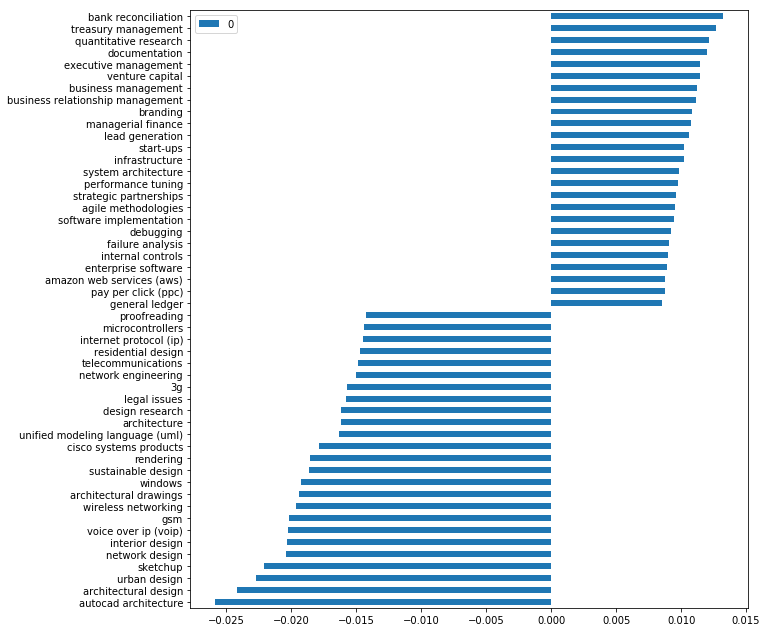

In [16]:
skillEffects = pd.Series(fitted.y_loadings_[0].dot(pc), index=pc.columns)

temp = pd.DataFrame(skillEffects).sort_values(by=0)
bins = np.arange(np.min(temp[0]), np.max(temp[0]) + 0.001, 0.001)
temp.head(25)
temp.tail(25).sort_values(by=0, ascending=False)

temp.head(25).append(temp.tail(25)).sort_values(by=0, ascending=True).plot(kind='barh', figsize=(10,11))

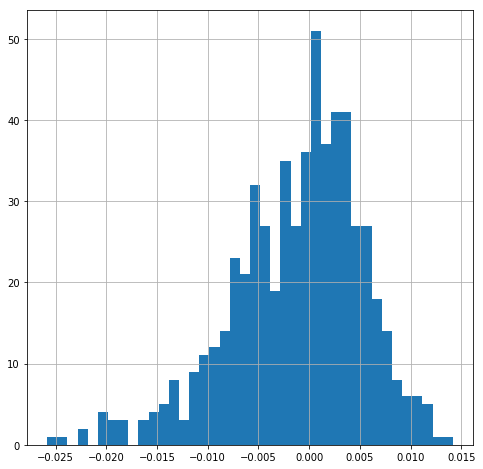

In [17]:
skillEffects.hist(bins=bins, figsize=(8,8))

right_only    34334
both            586
left_only         0
Name: _merge, dtype: int64

,skillEffect,skill_name,parent_skill_name,_merge


,skillEffect
parent_skill_name,
architecture,-0.183096
telecommunications,-0.106322
computer_networking,-0.105776
graphic_design,-0.104174
software_development,-0.084179
technical_support,-0.063872
insurance,-0.060013
media_production,-0.050549
electrical_engineering,-0.048545


,skillEffect
parent_skill_name,
accounting,0.118779
marketing,0.092510
business_strategy,0.061540
information_technology,0.060852
finance,0.047570
sales,0.037567
user_experience_design,0.020508
project_management,0.019698
analytics,0.011959


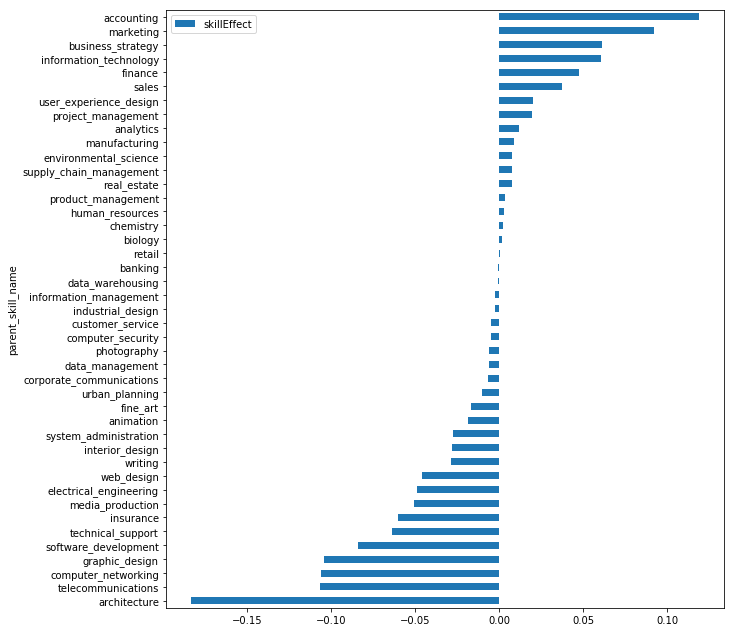

In [18]:
skillMaps = pd.read_csv('../00_originalData/li_parent_skill_map.tsv', sep='\t')[
             ['skill_name', 'parent_skill_name']]
skillMaps['skill_name'] = skillMaps['skill_name'].str.replace('_', ' ')

merged = pd.merge(pd.DataFrame(skillEffects, columns=['skillEffect']),
        skillMaps, left_index=True, right_on='skill_name',
        how='outer', indicator=True)
merged._merge.value_counts()
merged[merged._merge == 'left_only'].head() # orthopedic surgery, critical care nursing

parentSkillEffect = merged[['skillEffect', 'parent_skill_name']].groupby(
    by='parent_skill_name').sum()

parentSkillEffect = parentSkillEffect.sort_values(by=['skillEffect'])
parentSkillEffect[parentSkillEffect['skillEffect'] < 0]
parentSkillEffect[parentSkillEffect['skillEffect'] > 0].sort_values(by='skillEffect', ascending=False)

parentSkillEffect[parentSkillEffect['skillEffect'] < 0].append(
    parentSkillEffect[parentSkillEffect['skillEffect'] > 0]).plot(kind='barh', figsize=(10,11))

<Container object of 1582 artists>

Text(0.5,1,'Vector 1 (coef: 0.05992517484999305)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 0 (coef: 0.03448804300974614)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 2 (coef: 0.030773049453155725)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 4 (coef: 0.030357298308546273)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 3 (coef: 0.028190030731607377)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 5 (coef: -0.023203549636067845)')

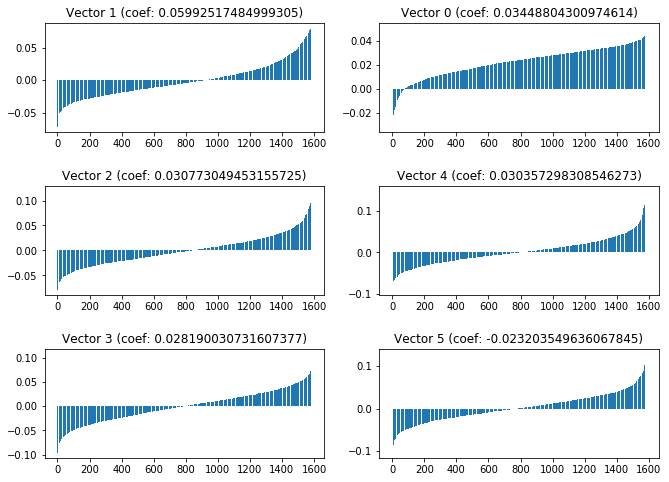

In [228]:
plt.figure(figsize=(11,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for position in np.arange(0, estimator.best_estimator_.steps[0][1].n_components):
    component = temp.index[position]
    plt.subplot(3,2, position + 1)
    plt.bar(np.arange(0, pc.iloc[component].shape[0]), pc.iloc[component].sort_values())
    plt.title('Vector {} (coef: {})'.format(component, pc.index[component]))

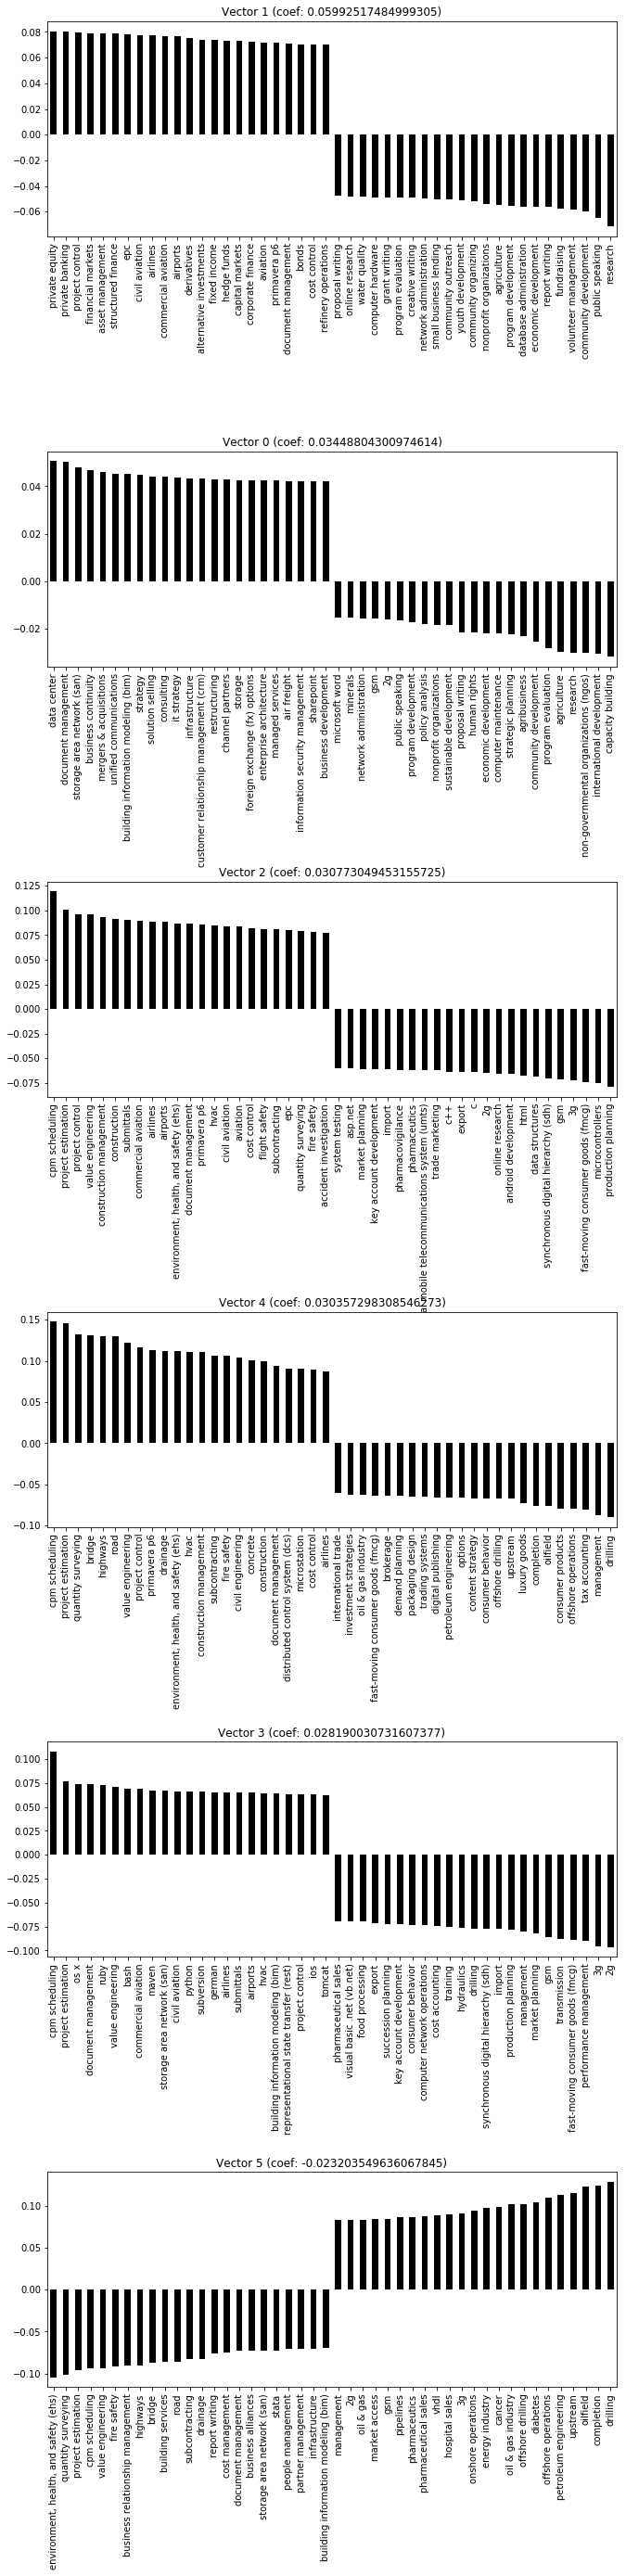

In [230]:
plt.figure(figsize=(11, 64))
plt.subplots_adjust(wspace=0.2, hspace=1.0)

components = pc.iloc[temp[0:estimator.best_estimator_.steps[0][1].n_components].index]
for i in np.arange(0, components.shape[0]):
    if pc.index[temp.index[i]] < 0:
        ascend = True
    else:
        ascend = False
    component = components.iloc[i].sort_values(ascending=ascend)
    component = component.iloc[0:23].append(component.iloc[-23:])
    plt.subplot(8,1, i + 1)
    component.plot.bar(colormap='gist_gray', 
                       title='Vector {} (coef: {})'.format(temp.index[i], pc.index[temp.index[i]]))
